In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import random
from statsmodels.stats.power import tt_ind_solve_power

def date_converter(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

Срок выполнения задания: 17 марта 17:00.


### Задание
Вам предстоит разработать дизайн эксперимента по тестированию монетизационных продуктов.
В конечном счёте, в монтизационных продуктах нас всегда интересует увеличение выручки, 
но к сожалению не всегда мы можем зафиксировать изменение именно этой метрики.

#### Кейс
Вы аналитик в продуктовой дискавери команде.
На текущий момент приближается начало нового квартала и вам необходимо спланировать
эксперименты в нём.

У вас есть два продукта:
- один базовый продукт, который предоставляет минимальный набор услуг на вашем ресурсе;
- один продвинутый продукт, который предоставляет расширенный набор услуг.

На текущий момент на квартал у вашей команды есть для проверки две гипотезы:
- Дополнительное информирование об эффективности услуг будет стимулировать их покупку;
- Повышение цены базового продукта должно стимулировать покупку продвинутого продукта


#### Для планирования эксперимента изучите данные и метрики (2 балла):

- Загрузите файл и изучите данные;
- Подумайте над тем, какие метрики можно выделить на основе этих данных: выручка, пользователи, транзакции, средний чек и т.д.
- Постройте графики плотности распределения для этих метрик и сделайте выводы о характере распределений: тип, наличие выбросов, насколько сильный разброс;
- Изучите основные статистики этих метрик: среднее, стандартное отклонение;
- Изучите то, насколько эти статистики подвержены сезональности.


#### Формализуйте гипотезы (4 балла):

- Опишите метрики и статистики, изменение которых вы ожидаете;
- Предположите какое относительное изменение этих статистик в процентах вы ожидаете.

#### Предскажите минимально детектируемый эффект для своих метрик и спланируйте эксперименты внутри квартала (4 балла):

- Принимая в расчёт максимально возможные размеры групп и ограничения по длительности в квартал рассмотрите разные планы проведения тестов и предскажите их чувствительность;
- Определите наиболее оптимальный план экспериментов. Обоснуйте, почему вы его считаете оптимальным.


#### * Оптимизация плана (2 балла):
Предложите варианты ускорения экспериментов — всегда могут образоваться ситуации, когда ваши гипотезы не подтвердились и они требуют изменения или уточнения и необходимости повторных тестов. Цели достигать всегда хорошо в рамках отведённого на них срока. Какие параметры экспериментов вы поменяете? К каким последствиям могут привести такие изменения?

#### Описание данныx

event_date - дата 

user_id - идентификатор пользователя

product - тип продукта

amount - сумма покупок

transactions - количество транзакций


In [3]:
df = pd.read_csv('user_transactions.csv')
df['event_date']=df.event_date.apply(date_converter)
df['avg_per_transaction'] = df['amount']/df['transactions']

### Задание 1

При исследовании будем смотреть: средний чек на пользователя, средний чек на й транзакцию, кол-во транзакций на одного пользователя. Также будем использовать разбивку по месяцам и тарифному плану  
Будем смотреть на долю клиентов  Advanced тарифом, суммарную прибыль по тарифам и месяцам, кол-во пользователей в каждом из тарифов

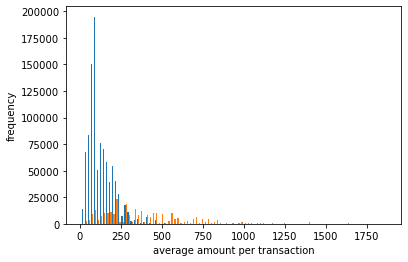

In [4]:
#Частота средних чеков для тарифов basic (красный) и advanced (синий)
import matplotlib.pyplot as plt
plt.hist([df[(df['product'] == 'basic')]['avg_per_transaction'], df[(df['product'] == 'advanced')]['avg_per_transaction']], bins=100)
plt.xlabel('average amount per transaction')
plt.ylabel('frequency')
plt.show()

По граффику выше можем сделать выводы:

У нас сильно больше Basic клиентов
При этом средняя сумма транзакции Basic клиентов сильно меньше, чем у Advanced. Рассмотрим avg, min и max, mean и sd. Будем рассматривать на одну транзакцию

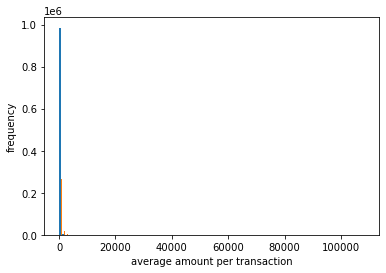

In [5]:
# Частота ARPU за 3 месяца для тарифов basic (красный) и advanced (синий)
# Видим выбросы, как для Basic тарифа, так и для Advanced 
import matplotlib.pyplot as plt
plt.hist([df[((df['product'] == 'basic'))]['amount'], 
          df[((df['product'] == 'advanced'))]['amount']], bins=100)
plt.xlabel('average amount per transaction')
plt.ylabel('frequency')
plt.show()

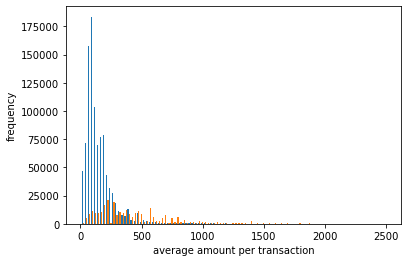

In [6]:
# Удалив выбросы, ограничив до 2500 максимальной суммы покупок на юзера
#Частота ARPU за 3 месяца для тарифов basic (красный) и advanced (синий)
import matplotlib.pyplot as plt
plt.hist([df[((df['product'] == 'basic') &  (df['amount'] < 2500))]['amount'], 
          df[((df['product'] == 'advanced') & (df['amount'] < 2500))]['amount']], bins=100)
plt.xlabel('average amount per transaction')
plt.ylabel('frequency')
plt.show()

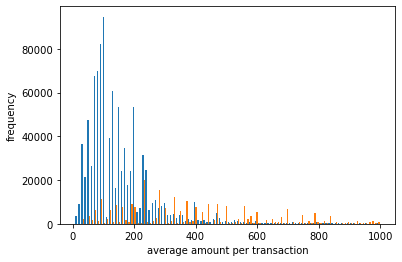

In [29]:
# Удалим больше выбросов, ограничив до 1000 максимальной суммы покупок на юзера
# Частота ARPU за 3 месяца для тарифов basic (красный) и advanced (синий)
import matplotlib.pyplot as plt
plt.hist([df[((df['product'] == 'basic') &  (df['amount'] < 1000))]['amount'], 
          df[((df['product'] == 'advanced') & (df['amount'] < 1000))]['amount']], bins=100)
plt.xlabel('average amount per transaction')
plt.ylabel('frequency')
plt.show()

# Advanced-users  равномерно распредлены в промежутке от 20 до 800. 
# Basic - users имеют распредление хи-квадрат, с пиком в 100.

In [7]:
# Посомотрим какой процент клиентов мы отсекли для basic  и Advanced
print('Отсекли Advanced процентов: ', 1 - (len(df[((df['product'] == 'advanced') & (df['amount'] < 2500))]) / len(df[(df['product'] == 'advanced')])))
print('Отсекли Basic процентов: ', 1 - (len(df[((df['product'] == 'basic') & (df['amount'] < 2500))]) / len(df[(df['product'] == 'basic')])))

Отсекли Advanced процентов:  0.012698169990061126
Отсекли Basic процентов:  0.0009410073220870174


По граффику выше можем сделать выводы:  
1. У нас сильно больше Basic клиентов  
2. При этом средняя сумма транзакции Basic клиентов сильно меньше, чем у Advanced.

Рассмотрим avg, min и max, mean и sd. Будем рассматривать на одну транзакцию

In [31]:
# Для всех клиентов
df.describe()

,user_id,amount,transactions,avg_per_transaction,event_date_1
count,1.278186e+06,1.278186e+06,1.278186e+06,1.278186e+06,1.278186e+06
mean,4.614241e+18,2.394618e+02,1.292690e+00,1.864859e+02,1.099585e+01
std,2.657074e+18,3.719033e+02,1.511153e+00,1.786732e+02,8.599128e-01
min,1.809139e+12,8.000000e+00,1.000000e+00,8.000000e+00,9.000000e+00
25%,2.311730e+18,8.900000e+01,1.000000e+00,8.000000e+01,1.000000e+01
50%,4.622499e+18,1.490000e+02,1.000000e+00,1.290000e+02,1.100000e+01
75%,6.906575e+18,2.590000e+02,1.000000e+00,2.290000e+02,1.200000e+01
max,9.223367e+18,1.081860e+05,7.680000e+02,1.869000e+03,1.200000e+01


In [30]:
# Для Advanced клиентов
df[(df['product'] == 'advanced')].describe()

,user_id,amount,transactions,avg_per_transaction,event_date_1
count,2.877580e+05,287758.000000,287758.000000,287758.000000,287758.000000
mean,4.603347e+18,499.179714,1.278383,388.828622,10.996156
std,2.646895e+18,583.444202,1.453016,261.807085,0.860337
min,1.809139e+12,20.000000,1.000000,20.000000,9.000000
25%,2.321055e+18,202.000000,1.000000,199.000000,10.000000
50%,4.620357e+18,369.000000,1.000000,330.000000,11.000000
75%,6.880639e+18,599.000000,1.000000,527.000000,12.000000
max,9.223367e+18,40653.000000,227.000000,1869.000000,12.000000


In [32]:
# Для Basic клиентов
df[(df['product'] == 'basic')].describe()

,user_id,amount,transactions,avg_per_transaction,event_date_1
count,9.904280e+05,990428.000000,990428.000000,990428.000000,990428.000000
mean,4.617406e+18,164.003625,1.296846,127.697391,10.995759
std,2.660018e+18,233.032281,1.527605,77.028749,0.859790
min,1.912220e+12,8.000000,1.000000,8.000000,9.000000
25%,2.309786e+18,80.000000,1.000000,76.000000,10.000000
50%,4.623599e+18,120.000000,1.000000,100.000000,11.000000
75%,6.915631e+18,199.000000,1.000000,169.000000,12.000000
max,9.223362e+18,108186.000000,768.000000,529.000000,12.000000


1. Кол-во транзакций и их дисперсия для Basic и Advanced тарифов почти не отличается
2. ARPU для Advanced пользователей в 3 раза больше, чем для Basic. Дисперсия в 2.5 раз больше
3. Средняя стоимость одной транзакции для Advanced в  3 раза больше, чем для Basic. Дисперсия в 3.4 раз больше

In [10]:
df['event_date_1'] = df['event_date'].dt.month

In [11]:
df_avg_price = df.groupby(by=['product', 'event_date_1']).mean()
df_avg_price
# в Декабре и ноябре для Basic тарифа средняя стоимость одной покупки выросла на 5%, для Advanced без изменений. 
# Можем считать, что наш продукт не особо сезонный

user_id      amount  transactions  \
product  event_date_1                                           
advanced 9             4.627273e+18  475.132883      1.246336   
         10            4.601329e+18  474.421729      1.254109   
         11            4.620621e+18  507.008238      1.293684   
         12            4.587606e+18  515.374780      1.287678   
basic    9             4.592986e+18  165.451553      1.270018   
         10            4.619458e+18  162.865842      1.284756   
         11            4.614787e+18  164.165401      1.296010   
         12            4.619476e+18  164.781583      1.310022   

                       avg_per_transaction  
product  event_date_1                       
advanced 9                      377.084852  
         10                     376.525312  
         11                     392.095872  
         12                     397.444204  
basic    9                      131.743173  
         10                     128.459256  
         11                     127.764280  
         12                     126.712833

In [12]:
# Посмотрим сколько денег мы получали в каждом месяце в разбивке по тарифному плану клиента
# сентябрь обгызанный, попало только 3 дня
df_sum_price = df.groupby(by=['event_date_1', 'product']).sum()
df_sum_price

user_id      amount  transactions  \
event_date_1 product                                            
9            advanced  2.810143e+22   2885482.0        7569.0   
             basic     9.447314e+22   3403173.0       26123.0   
10           advanced  4.087453e+23  42143831.0      111405.0   
             basic     1.415785e+24  49915612.0      393756.0   
11           advanced  4.296299e+23  47142133.0      120288.0   
             basic     1.476524e+24  52525541.0      414665.0   
12           advanced  4.581734e+23  51471510.0      128603.0   
             basic     1.586425e+24  56589456.0      449889.0   

                       avg_per_transaction  
event_date_1 product                        
9            advanced         2.290036e+06  
             basic            2.709825e+06  
10           advanced         3.344750e+07  
             basic            3.937058e+07  
11           advanced         3.645747e+07  
             basic            4.087882e+07  
12           advanced         3.969355e+07  
             basic            4.351585e+07

In [28]:
df_count_price = df.groupby(by=['product', 'event_date']).count()
df_count_price

user_id  amount  transactions  avg_per_transaction  \
product  event_date                                                       
advanced 2020-09-29     2967    2967          2967                 2967   
         2020-09-30     3106    3106          3106                 3106   
         2020-10-01     2896    2896          2896                 2896   
         2020-10-02     2897    2897          2897                 2897   
         2020-10-03     2440    2440          2440                 2440   
...                      ...     ...           ...                  ...   
basic    2020-12-25    12693   12693         12693                12693   
         2020-12-26    11289   11289         11289                11289   
         2020-12-27     9784    9784          9784                 9784   
         2020-12-28    13702   13702         13702                13702   
         2020-12-29    12764   12764         12764                12764   

                     event_date_1  
product  event_date                
advanced 2020-09-29          2967  
         2020-09-30          3106  
         2020-10-01          2896  
         2020-10-02          2897  
         2020-10-03          2440  
...                           ...  
basic    2020-12-25         12693  
         2020-12-26         11289  
         2020-12-27          9784  
         2020-12-28         13702  
         2020-12-29         12764  

[184 rows x 5 columns]

In [14]:
#Basic vs Advanced
print ('Сумма от advanced клиентов за 3 месяца:', df[(df['product'] == 'advanced')]['amount'].sum())
print ('Сумма от basic клиентов за 3 месяца:', df[(df['product'] == 'basic')]['amount'].sum())

print ('Кол-во юзеров за 3 месяца на advanced тарифе:',df[(df['product'] == 'advanced')]['user_id'].count())
print ('Кол-во юзеров за 3 месяца на  basic тарифе:', df[(df['product'] == 'basic')]['user_id'].count())
print ('Доля пользователей с advanced тарифом:', (df[(df['product'] == 'advanced')]['user_id'].count())/ (df['user_id'].count()))

Сумма от advanced клиентов за 3 месяца: 143642956.0
Сумма от basic клиентов за 3 месяца: 162433782.0
Кол-во юзеров за 3 месяца на advanced тарифе: 287758
Кол-во юзеров за 3 месяца на  basic тарифе: 990428
Доля пользователей с advanced тарифом: 0.22512998890615293


### Задание 2

**Гипотеза 1**: Дополнительное информирование об эффективности услуг будет стимулировать их покупку

Целевой метрикой выберем увеличение доли Advanced клиентов среди всех, при этом будем следить, чтобы метрика ARPPU (amount) не упала. Также будем считать в эксперементе, что информирование не настолько плохое, что мы отпугнем итех клиентов, кто мог стать Basic.

Результат будет зависеть от качества нового информирования, разницы стоимости Basic и Advanced, простоте подключения и тд.  
Так  что очень примерно +10% относительных процентов к Доле пользователей Advanced. 22.5% -> 24.75%

**Гипотеза 2**: Повышение цены базового продукта должно стимулировать покупку продвинутого продукта 

Целевая метрика: получить больше прибыли -> будем смотреть на ARPU (amount). Также будем смотреть на долю подключенных advanced, возможно доля advanced не вырастет, но за счет повышения цены на базовый тариф, прибыль вырастет (как вариант, может добавиться ценность продукту в глазах клиента из-за более выоской цены)  
Относительной изменение (также очень примерное) +5% к текущей. Также есть вероятный сценрий, что окажется, что пользователи не будут готовы покупать Basic по более дорогой цене и прибыль упадет


 ### Задание 3
 

Тесты рассчитываем на Q1 2021, а данные только за Q4 2020. 
Мы наблюдали, что у нас не большой эффект сезонности, так что нам ок рассчитать тесты на данных Q4

В задании выше мы определили две самых интерсующих нас метрики: ARPU (amount), кол-во транзакций (чтобы проверить, что пользователей не стало меньше)и изменение доли Advanced клиентов. Для рассчета MDE теста, возьмем показатель прибыли с клиента, а изменения доли Advanced подписок(стат значимо или нет) сможем рассчитать с помощью Мана-Уитни или Бутстрапа (не будем в этом дз, но можем). Так, будем смотреть, сколько нужно будет крутиться тесту с +4 относительных процентов к прибыли от клиента.

In [17]:
def choose_date(df, start_date, delta, share): 
    tmp = df[(df.event_date>=start_date)&(df.event_date<=start_date+datetime.timedelta(days=delta))]
    tmp=tmp.groupby(['user_id']).sum().reset_index()
    x = tmp[(tmp.user_id)%int(1/share)==1].reset_index()
    return x

In [22]:
# Эксперимент будем проводить на всей выборке.
import datetime

x1 = choose_date(df, datetime.datetime(2020, 9, 29, 0, 0),3,0.5) #получаем необходимую подвыборку

from statsmodels.stats.power import tt_ind_solve_power
 
mean = x1.transactions.mean()
std = x1.transactions.std()
 
alpha = 0.05
power = 0.8
result_effect = 0.10 # целевой размер относительного отклоенения исходной метрики
effect_size = (mean /std) * result_effect
 
    
sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')    
print(sample_vol/x1.shape[0])# получаем множитель того, во сколько раз необходимо изменить размер выборки

# За 3 дня сможем задетектить измнения в кол-ве транзакций, этот тест нам важно провести, чтобы понять, увеличили ли/уменьшили ли мы кол-во покупок
# (особенно при проверке второй гипотезы)
# Будем тестировать 7 дней, чтобы убедиться, что не будет эффекта от дня недели


0.9653864811988622


In [26]:
# Эксперимент будем проводить на всей выборке.
import datetime

x1 = choose_date(df, datetime.datetime(2020, 9, 29, 0, 0),30,0.5) #получаем необходимую подвыборку

from statsmodels.stats.power import tt_ind_solve_power
 
mean = x1.amount.mean()
std = x1.amount.std()
 
alpha = 0.05
power = 0.8
result_effect = 0.05 # целевой размер относительного отклоенения исходной метрики
effect_size = (mean /std) * result_effect
 
    
sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')    
print(sample_vol/x1.shape[0])# получаем множитель того, во сколько раз необходимо изменить размер выборки

# Сможем задокументировать изменения в 5% на средний чек на пользователя за 45 дней

1.0492095185266044


С уровнем значимости 5% мы можем провести 2 теста, каждый по 30 дней + 14 дней (по 7 на каждый) для тестов с кол-вом транзакций. С продуктовой точки зрения предложила бы сначала проверить первую гипотезу, так как информирование выглядит более простым решением и точно "не сделает хуже". Вторая гипотеза более спорная, и более рисковая, так как увеличения цен на базовый тариф сможет отпугнуть клиентов

Итого нам понадобится 54 дня на тесты. Также я бы заложила +10 дней на увеличение теста во время январских праздников, так как люди отдыхают, и возможно не будут просматривать объявления

### Задача 4

Для оптимизации времени проведения тестов можно попробовать:  
1. Поменять гипотезу на одностороннюю, так мы увеличим критическую область для p-value
2. Можем попробовать задетектить больший MDE, так нам потребуется меньше пользователей